In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.preprocessing import PolynomialFeatures

from joblib import dump, load
import pickle

    
def Graph_Confusion_Matrix(CM, labels, title = 'Confusion Matrix'):
    #np.fill_diagonal(CM,0)

    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(CM, annot=True,annot_kws={"size": 16},  fmt='.1f' # fmt='g'
               ,xticklabels = labels
               ,yticklabels = labels)# font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def Normalisation(X):
    #X = X.values
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_norm = (X - X_mean)/X_std
    return(X_norm, X_mean, X_std)
    
def Max_Min_Norm(X):
    #X = X.values
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_norm = (X-X_min)/(X_max-X_min)
    return(X_norm, X_min, X_max)

plt.style.use('bmh')

In [2]:
df = pd.read_csv("Data/Train_Data_Aft_FE.csv")
df = df.set_index("URN")
K_mean = load('Parameter_Dictionary/k-means.joblib') 

#Load dictionary that has mean and std for k-means
with open('Parameter_Dictionary/K_means_Dict.pickle', 'rb') as handle:
    Para_Dict = pickle.load(handle)

df.drop(["Mosaic Group Num"],axis=1, inplace=True)


#### These are catergorical variables and for this algorithm they can not be used therefore they are being dropped

In [3]:
columns_to_encode =[
'SEX',
'TITLE',
'TOWN',
'OAC_Group',
'COG_TYPE']

for i, col in enumerate(columns_to_encode):
    df.drop([col+"_Encoded"], axis=1, inplace=True)

## Need to add on the customer segments

In [4]:
df_k_means = df[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means["Recency"] = np.where((df_k_means['NUM_TRANS_LST_24']>0),1,0)

X_k_means = (df_k_means.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [5]:
df = pd.concat([df,pd.get_dummies(pd.Series(K_mean.predict(X_k_means), index=df.index))],axis=1)

df.drop(['Months Between DateCr and Last Ask',
'AGE',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'Total_C0',
'NUM_TRANS_LST_24',
'DONATED_LST_24'], axis=1, inplace=True)

In [6]:
Num_DV_1 = len(df.loc[df["DV"] == 1])

df_final = pd.concat([df.loc[df["DV"] == 1], df.loc[df["DV"] == 0].sample(Num_DV_1, random_state=32)]).copy()
df_final = df_final.sample(frac=1, random_state=53)#.reset_index(drop=True)

In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19036 entries, 87358 to 28144
Data columns (total 29 columns):
DV                                    19036 non-null int64
INCOME                                9518 non-null float64
APPEAL_AVG_GIFT                       19036 non-null float64
EMERG_AVG_GIFT                        19036 non-null float64
EMAIL_FLAG                            19036 non-null int64
NUM_ACTIVE_COG                        19036 non-null int64
NUM_ATTRITED_COG                      19036 non-null int64
NUM_DIFF_COG                          19036 non-null int64
TOTAL_YEARLY_CHARGE                   19036 non-null float64
TOTAL_NUM_MONTH_PAID                  19036 non-null int64
DM_PREVIOUS_12_MONTHS                 19036 non-null int64
NUM_TRANS_LST_24                      19036 non-null int64
DONATED_LST_24                        19036 non-null float64
Months Between DateCr and Last Ask    19036 non-null float64
AGE                                   19036 non-nu

In [8]:
y = df_final["DV"].copy()
X = df_final.drop(["DV","INCOME"],axis=1).copy()

In [9]:
X_norm, X_mean, X_std = Normalisation(X.values)

#Makes it back into a dataframe far more easily readable
X_norm_df = pd.DataFrame(X_norm, columns=X.columns)

In [10]:
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'n_estimators': [64,128,256,512], 
                     'max_depth': [5, 10,15,20],
                     'max_features': [3,5,7,10,15],
                     'min_samples_leaf':[5,10,20,30]
                    }]
scores = ['precision', 'recall']

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters,   cv=5, scoring = 'recall', verbose=5)
clf.fit(X, y)
print(clf.best_params_)

In [17]:
Acc = 0
Best_Acc = 0

Train_Acc = []
Test_Acc = []
Test_Recall = []


# Feature extraction
model = LogisticRegression(solver='liblinear')
rfe = RFE(model, 1)
fit = rfe.fit(X_norm, y)
print("Num Features: %s" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
#print("Feature Ranking: %s" % (fit.ranking_))

#Turning the fit into a pandas dataframe for feature selection
Features_Ranked = pd.DataFrame(fit.ranking_, index=X.columns).sort_values(by=0)

#for i, col in enumerate (Features):
for i in range(1,X_norm.shape[1]):
    #print(col)
    
    #Select the feature that the RFE above picked as the best features
    Feature_Selection = Features_Ranked.loc[Features_Ranked[0]<=i]
    
    print(Feature_Selection)
    
    Acc_Train = []
    Acc = []
    Recall = []
    Precision = []
    
    folds = KFold(n_splits=5, shuffle=False)#, random_state=42)
    
    Model = LogisticRegression(solver='liblinear')

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_norm_df, y)):    

        #print("Kfold: ",fold_)

        Model.fit(X_norm_df.iloc[trn_idx][Feature_Selection.index], y.iloc[trn_idx])

        y_pred_prob = Model.predict_proba(X_norm_df.iloc[val_idx][Feature_Selection.index])[:,1]

        y_pred = y_pred_prob >= 0.5

        #CM = confusion_matrix(y.iloc[val_idx].values, y_pred, labels)
        #Graph_Confusion_Matrix(CM, labels)

        Y_actual = y.iloc[val_idx]

        Acc_Train.append(accuracy_score(y.iloc[trn_idx], Model.predict(X_norm_df.iloc[trn_idx][Feature_Selection.index]) >=0.5 )*100)

        Acc.append(accuracy_score(Y_actual, y_pred)*100)
        Recall.append(recall_score(Y_actual, y_pred)*100)
        Precision.append(precision_score(Y_actual, y_pred)*100)

    Train_Acc.append(np.mean(Acc_Train))
    Test_Acc.append(np.mean(Acc))
    Test_Recall.append(np.mean(Recall))

Num Features: 1
           0
WRR_EMERG  1
                0
WRR_EMERG       1
NUM_ACTIVE_COG  2
                  0
WRR_EMERG         1
NUM_ACTIVE_COG    2
NUM_TRANS_LST_24  3
                  0
WRR_EMERG         1
NUM_ACTIVE_COG    2
NUM_TRANS_LST_24  3
AGE               4
                  0
WRR_EMERG         1
NUM_ACTIVE_COG    2
NUM_TRANS_LST_24  3
AGE               4
WRR_APP           5
                                    0
WRR_EMERG                           1
NUM_ACTIVE_COG                      2
NUM_TRANS_LST_24                    3
AGE                                 4
WRR_APP                             5
Months Between DateCr and Last Ask  6
                                    0
WRR_EMERG                           1
NUM_ACTIVE_COG                      2
NUM_TRANS_LST_24                    3
AGE                                 4
WRR_APP                             5
Months Between DateCr and Last Ask  6
APPEAL_AVG_GIFT                     7
                                  

                                     0
WRR_EMERG                            1
NUM_ACTIVE_COG                       2
NUM_TRANS_LST_24                     3
AGE                                  4
WRR_APP                              5
Months Between DateCr and Last Ask   6
APPEAL_AVG_GIFT                      7
TOWNC1                               8
TOTAL_NUM_MONTH_PAID                 9
NUM_ATTRITED_COG                    10
EMAIL_FLAG                          11
Mosaic GroupC1                      12
0                                   13
SEXC1                               14
TITLEC1                             15
TOTAL_YEARLY_CHARGE                 16
Total_C1                            17
NUM_DIFF_COG                        18
OAC_GroupC1                         19
COG_TYPEC1                          20
4                                   21
                                     0
WRR_EMERG                            1
NUM_ACTIVE_COG                       2
NUM_TRANS_LST_24         

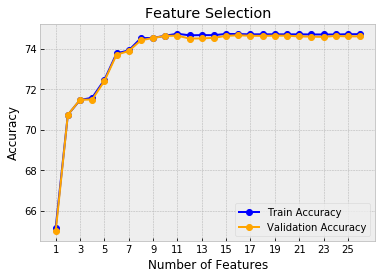

In [20]:
#plots the accuary after each new feature is added.
plt.plot(range(1,i+1), Train_Acc, linestyle='-', marker='o', color='b', label="Train Accuracy")
plt.plot(range(1,i+1), Test_Acc,  linestyle='-', marker='o', color='orange', label="Validation Accuracy")
#plt.plot(range(1,i+1), Test_Recall,  linestyle='-', marker='o', color='green', label="Test Recall")

plt.xticks(range(1,i+1,2))
plt.title("Feature Selection")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
Features_Ranked.rename(index=str,columns={0:"RFE Rank"}).head(10)

,RFE Rank
WRR_EMERG,1
NUM_ACTIVE_COG,2
NUM_TRANS_LST_24,3
AGE,4
WRR_APP,5
Months Between DateCr and Last Ask,6
COG_TYPE_Encoded,7
NUM_DIFF_COG,8
APPEAL_AVG_GIFT,9
TOWNC1,10


In [12]:
poly = PolynomialFeatures(3)

X_norm_df_2 = pd.DataFrame(poly.fit_transform(X_norm_df[Features_Ranked.rename(index=str,columns={0:"RFE Rank"}).head(10).index]))

In [13]:
X_norm_df_2.shape

(19036, 286)

#### Create Polynomials features based on the top 5 RFE features

In [17]:
Model = LogisticRegression(solver='liblinear', max_iter=200)

Acc_Train = []
Acc = []
Recall = []
Precision = []

labels=[1,0]

folds = KFold(n_splits=10, shuffle=False)#, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_norm_df, y)):    
    
    print("Kfold: ",fold_)
    
    Model.fit(X_norm_df_2.iloc[trn_idx], y.iloc[trn_idx])

    y_pred_prob = Model.predict_proba(X_norm_df_2.iloc[val_idx])[:,1]
    
    y_pred = y_pred_prob >= 0.5
    
    #CM = confusion_matrix(y.iloc[val_idx].values, y_pred, labels)
    #Graph_Confusion_Matrix(CM, labels)
    
    Y_actual = y.iloc[val_idx]
    
    Acc_Train.append(accuracy_score(y.iloc[trn_idx], Model.predict(X_norm_df_2.iloc[trn_idx]) >=0.5 )*100)
    
    Acc.append(accuracy_score(Y_actual, y_pred)*100)
    Recall.append(recall_score(Y_actual, y_pred)*100)
    Precision.append(precision_score(Y_actual, y_pred)*100)

    #print("Accuary:", accuracy_score(Y_actual, y_pred)*100)
    #print("Recall:", recall_score(Y_actual, y_pred)*100)
    #print("Precision:", precision_score(Y_actual, y_pred)*100)
    
    if fold_ == 0:
        Outcome_df = pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1)
    else:
        Outcome_df = Outcome_df.append(pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1), sort=False)
        
Outcome_df.rename(index=str, columns={0:"Score"}, inplace=True)

print("Avg Accuracy Train Set:", np.mean(Acc_Train))
print("Avg Accuracy Test Set:",np.mean(Acc))
print("")
print("Avg Recall:",np.mean(Recall))
print("Avg Precision:",np.mean(Precision))

#Outcome_df.to_csv("Model Outputs/Logistic_Regression.csv", index=True)

Kfold:  0
Kfold:  1
Kfold:  2
Kfold:  3
Kfold:  4
Kfold:  5
Kfold:  6
Kfold:  7
Kfold:  8
Kfold:  9
Avg Accuracy Train Set: 77.49235486352197
Avg Accuracy Test Set: 76.69163737486588

Avg Recall: 74.32069385624891
Avg Precision: 78.05291725646936


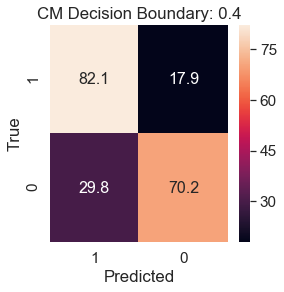

Accuracy: 76.13994536667367
Recall: 82.05505358268543
Precision: 73.37467117624954


In [18]:
Boundry = 0.4

CM = confusion_matrix(Outcome_df["DV"], Outcome_df["Score"]>=Boundry, labels)

#Normalise so is a percentage
CM = np.divide(CM,np.sum(CM, axis=1).reshape(2,-1)) * 100

Graph_Confusion_Matrix(CM, labels, 'CM Decision Boundary: '+str(Boundry))

print("Accuracy:", accuracy_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Recall:", recall_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Precision:", precision_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)

In [ ]:
fpr, tpr, _ = roc_curve(Outcome_df["DV"], Outcome_df["Score"])
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Outcome_df["Score Band"] = Outcome_df["Score"].astype(str).str.slice(0,3)

### I am now going to do the same to this dataset and add on the customer segments

In [16]:
df_Val = pd.read_csv("Data/Test_Data_Val_Aft_FE.csv")
df_Val = df_Val.set_index("URN")

df_Val.drop(["Mosaic Group Num"],axis=1, inplace=True)

In [17]:
df_k_means_val = df_Val[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means_val["Recency"] = np.where((df_k_means_val['NUM_TRANS_LST_24']>0),1,0)

X_k_means_val = (df_k_means_val.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [18]:
df_Val = pd.concat([df_Val,pd.get_dummies(pd.Series(K_mean.predict(X_k_means_val), index=df_Val.index))],axis=1)

X_val_norm = (df_Val.drop(["DV","INCOME"],axis=1).values - X_mean)/X_std

#Makes it back into a dataframe far more easily readable
X_norm_val_df = pd.DataFrame(X_val_norm, columns=X.columns)

In [19]:
X_norm_val_2 = poly.transform(X_norm_val_df[Features_Ranked.rename(index=str,columns={0:"RFE Rank"}).head(10).index].values)

### Fit the model to all of the data

In [14]:
#Fit all of the data not just the last KFold
Model = LogisticRegression(solver='liblinear', max_iter=200)
Model.fit(X_norm_df_2, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### Save the model to desk

In [24]:
dump(Model, 'Parameter_Dictionary/LR_poly_3.joblib') 

['Parameter_Dictionary/LR_poly_3.joblib']

#### Let check the net profit and response rate for the unbalanced dataset

In [20]:
Results_Val = df_Val[["DV", "INCOME"]].copy()
Results_Val["Score"] =  Model.predict_proba(X_norm_val_2)[:,1]
Results_Val = Results_Val.round(4)
Results_Val["Score Band"] = Results_Val["Score"].astype(str).str.slice(0,3)

Results_Val.to_csv("Model Outputs/Logistic_Regression_UB_VAL.csv", index=True)

In [21]:
Results_Val_2 = Results_Val.groupby(["Score Band"])["INCOME"].agg(["count", "sum", "mean","median","std" ,"max"])
Results_Val_2 = pd.concat([Results_Val["Score Band"].value_counts().sort_index(), Results_Val_2],axis=1).rename(index=str
                                                                                                                 ,columns={"count":"Donors"
                                                                                                                           ,"Score Band": "Contacted Volume"
                                                                                                                           ,"sum": "Total Value"
                                                                                                                           ,"mean": "Mean Gift"
                                                                                                                           ,"median": "Median Gift"
                                                                                                                           ,"max":"Max Gift"})



In [22]:
Results_Val_2["Cost"]= Results_Val_2["Contacted Volume"] * 2.50
Results_Val_2["Net Profit"] = Results_Val_2["Total Value"] - Results_Val_2["Cost"]
Results_Val_2["RR"] = (Results_Val_2["Donors"]/Results_Val_2["Contacted Volume"])
Results_Val_2

,Contacted Volume,Donors,Total Value,Mean Gift,Median Gift,std,Max Gift,Cost,Net Profit,RR
Score Band,,,,,,,,,,
0.0,1946,25,1295.00,51.800000,50.0,35.791060,100.0,4865.0,-3570.00,0.012847
0.1,2467,50,2000.00,40.000000,30.0,70.269162,500.0,6167.5,-4167.50,0.020268
0.2,1989,78,3058.00,39.205128,30.0,34.485216,200.0,4972.5,-1914.50,0.039216
0.3,1886,85,3489.00,41.047059,30.0,38.660274,200.0,4715.0,-1226.00,0.045069
0.4,1352,98,4893.00,49.928571,30.0,104.239440,1000.0,3380.0,1513.00,0.072485
0.5,1216,127,4697.81,36.990630,30.0,30.033749,200.0,3040.0,1657.81,0.104441
0.6,773,112,4936.00,44.071429,30.0,35.423745,250.0,1932.5,3003.50,0.144890
0.7,647,131,7122.00,54.366412,30.0,98.341885,1000.0,1617.5,5504.50,0.202473
0.8,629,249,14603.00,58.646586,30.0,91.332848,1000.0,1572.5,13030.50,0.395866


We now want to create a gains and lift chart for the net profit

In [ ]:
Gains_df = Results_Val_2[["Contacted Volume","Cost", "Total Value"]].copy()

In [ ]:
#Sort the index
Gains_df = Gains_df.sort_index(ascending=False)

Gains_df["Random Contacted"] = Gains_df["Contacted Volume"].sum()//10
Gains_df["Random Cost"] = Gains_df["Cost"].sum()/10
Gains_df["Random Total Val"] = Gains_df["Total Value"].sum()/10

#Cumlativbe sum for each column
Gains_df = Gains_df.cumsum()

In [ ]:
Gains_df["Net Profit"] = Gains_df["Total Value"] - Gains_df["Cost"]
Gains_df["Random Net Profit"] = Gains_df["Random Total Val"] - Gains_df["Random Cost"]
Gains_df["% Difference"] = ((Gains_df["Net Profit"] - Gains_df["Random Net Profit"]) / Gains_df["Random Net Profit"])*100


In [ ]:
Gains_df[["Net Profit", "Random Net Profit", "% Difference"]].round(4)

In [ ]:
plt.plot(Gains_df.index, Gains_df["Random Total Val"].values)
plt.plot(Gains_df.index, Gains_df["Total Value"].values)